In [1]:
import numpy as np
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## NOTES:
- Download "allStar-l31c.2.fits" from  https://www.sdss.org/dr15/irspec/spectro_data/#catalogs
- Download "apogee_distances-DR14.fits" from https://data.sdss.org/sas/dr14/apogee/vac/apogee-distances/    
- Paper reference for distance: https://arxiv.org/pdf/1611.01249.pdf    
- More documentation and paper references for the distances dataset: https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=apogee-dr14-based-distance-estimations/

In [2]:
#Adapted from APOGEE Documentation
#https://www.sdss.org/dr14

star_hdus = astropy.io.fits.open('allStar-l31c.2.fits')
dist_hdus= astropy.io.fits.open('apogee_distances-DR14.fits')
dist = dist_hdus[1].data
star = star_hdus[1].data
dist_hdus.close()
star_hdus.close()

badbits = 2**23
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & (star['extratarg']==0)

ind = np.where(gd)[0]

distances=[]
FEonHs= []
skipped = []
ras=[]
decs=[]


def rad_calc(d,l,b, R_sun= 8.0):
    return np.sqrt(d**2+R_sun**2-(2*d*R_sun*np.cos(np.radians(l))*np.cos(np.radians(b))))


for i in range(0, 25000):
    j = ind[i]
    #Check that the names are the same
    star_dat = star["ASPCAP_ID"][j]
    star_dist = dist["ASPCAP_ID"][j]
    if star_dat == star_dist:
        if star['fe_h'][j] >= -100:
            if np.isnan(dist['BPG_meandist'][j]) == False:
                d= dist['BPG_meandist'][j]
                z= d*np.sin(np.radians(star['glat'][j]))
                if abs(z)<= 0.5:
                    new_dist= rad_calc(d,star['glon'][j],star['glat'][j])
                    distances.append(new_dist)
                    FEonHs.append(star['fe_h'][j])
                    ras.append(star['glon'][j])
                    decs.append(star['glat'][j])
        else:
            pair = (star_dat, star_dist)
            skipped.append(pair)   
    else: 
        pair = (star_dat, star_dist)
        skipped.append(pair)


-0.08666547


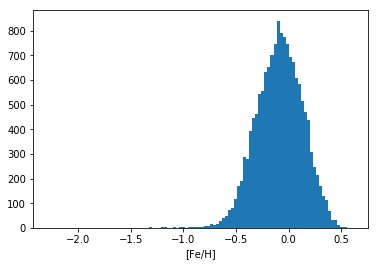

In [14]:
plt.hist(FEonHs, bins=100)
plt.xlabel("[Fe/H]")
print(np.array(FEonHs).mean())

## Below results not necessary

In [4]:
#let's bin these based on 0.5 kpc
master_dist=np.arange(8.0,19.5, 0.5)
master_feh=np.zeros(len(master_dist))
c=0
for i in master_dist:
    temp=[]
    for j in range(len(distances)):
        if distances[j]>= i and distances[j] < i+1:
            temp.append(FEonHs[j])
        else:
            continue
    master_feh[c]= np.mean(temp)
    c+=1

In [5]:
def func(x, m, b):
    return m*x+b

popt, pcov = curve_fit(func, master_dist[0:9], master_feh[0:9])

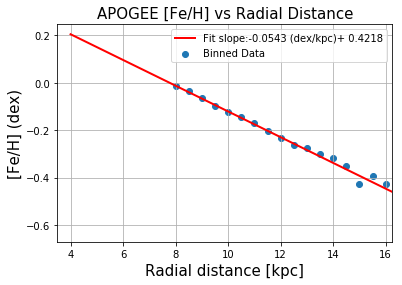

In [6]:
master_new=np.arange(4.0,19.5, 0.5)
plt.scatter(master_dist, master_feh, label='Binned Data')
plt.plot(master_new, func(master_new, *popt), 'r',linewidth=2.0, label= "Fit slope:{0:.4f} (dex/kpc)+ {1:.4f}".format(popt[0],popt[1]))
plt.legend()
plt.xlabel("Radial distance [kpc]", fontsize= 15)
plt.ylabel("[Fe/H] (dex)", fontsize= 15)
plt.xlim(3.5,16.25)
plt.title("APOGEE [Fe/H] vs Radial Distance", fontsize= 15)
plt.grid()
plt.savefig("APOGEE_reduct_z05.jpg", bbox_inches='tight', dpi=500 )

In [7]:
import csv

csvData = []

for i in range(len(master_feh)):
    temp=[]
    temp.append(master_dist[i])
    temp.append(master_feh[i])
    csvData.append(temp)

with open('apogee_masters.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

## Where are all of these targets?

In [8]:
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u

j = ind[14]
#Check that the names are the same
star_dat = star["ASPCAP_ID"][j]
star_dist = dist["ASPCAP_ID"][j]
if star_dat == star_dist:
    k= dist['BPG_meandist'][j]*1000
    b= star['glat'][j]
    l= star['glon'][j]

SkyCoord(l*u.deg, b*u.deg, distance= k*u.pc, frame='galactic')

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (115.87443092, -5.59299166, 4735.81552505)>

In [9]:
#ras_r = np.radians(ras)
#decs_r = np.radians(decs)
r2 = star['glon']
d2= star['glat']


import astropy.coordinates as coord
ra = coord.Angle(star['glon']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(star['glat']*u.degree)
#dec = dec.wrap_at(90*u.degree)

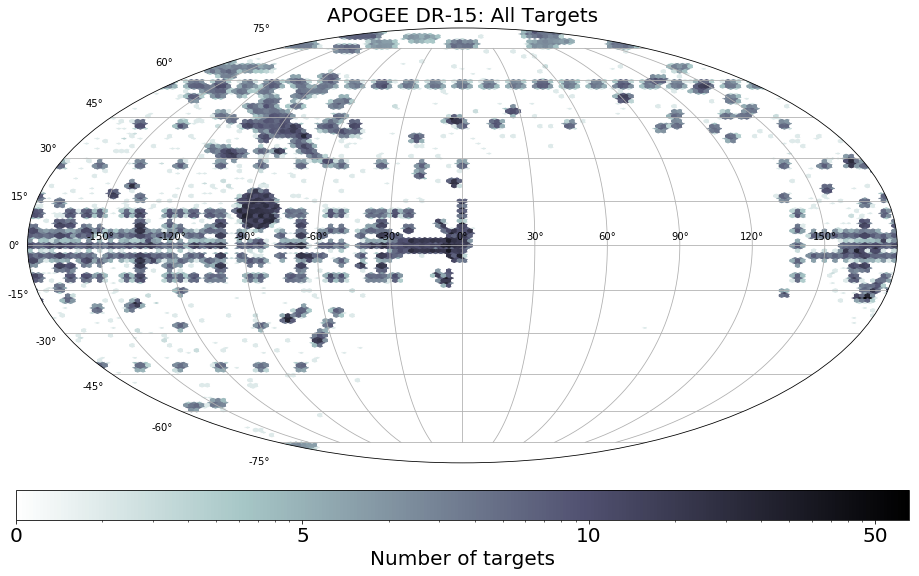

In [10]:
#they split their data by 15 points (x) and 10 points (y)
#delta= 2
#X= np.arange(-180, 180+delta, delta)
#Y= np.arange(-90,90+delta, delta)

#this works, consider changing projection
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1, projection='mollweide', title= "APOGEE DR-15: All Targets")

#using hexbin to bin nasty data, lots of points in small places
#ax.scatter(-ra.radian, dec.radian)
hb= ax.hexbin(-ra.radian, dec.radian,gridsize=(180,90), bins='log', cmap="bone_r")
cb = fig.colorbar(hb, orientation="horizontal",aspect=30, pad=0.05)
cb.set_label('Number of targets', fontsize= 20)
cb.ax.set_xticklabels([0,5, 10,50, 100,500, 1000], fontsize=20)
ax.grid()
ax.set_title("APOGEE DR-15: All Targets", fontsize= 20)
plt.savefig("All_targets.jpg", bbox_inches='tight', dpi=800)